In [1]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(physical_devices[1:],'GPU')
tf.executing_eagerly()
print(tf.executing_eagerly())

True


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [3]:
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

import math
import random
import time

import functools

In [4]:
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import datasets, Input, layers, models, Model, losses
from sklearn.preprocessing import MinMaxScaler

In [5]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM
from IPython import display
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

In [6]:
physical_devices = tf.config.list_physical_devices('GPU') 
for gpu_instance in physical_devices: 
    tf.config.experimental.set_memory_growth(gpu_instance, True)

In [7]:
tf.device('/GPU:1')
tf.config.experimental.list_physical_devices('GPU')

strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [8]:
#session=InteractiveSession(config=config)
#session.close()

# Input data stream

In [9]:
num_param = 10
num_time = 800
num_node = 14300
num_var = 1

n_epochs = 20000
batch_size = 10
LR =2e-5
Lv1_latent_dim = 64

alpha = 50

In [10]:
data_save = np.zeros((num_var, num_node,num_param*num_time))
data = np.zeros((num_node,num_param*num_time))

"""
data = pd.read_csv('input_data/FOM_u_sorted.csv', header = None)
print(data.shape)
#print(data)
data_save[0,0:num_node,:]=data.values[0:num_node,:]


del(data)
data = pd.read_csv('input_data/FOM_v_sorted.csv', header = None)
print(data.shape)
data_save[1,0:num_node,:]=data.values[0:num_node,:]
"""
"""
del(data)
data = pd.read_csv('input_data/FOM_x_sorted.csv', header = None)
print(data.shape)
data_save[0,0:num_node,:]=data.values[0:num_node,:]

"""
del(data)
data = pd.read_csv('input_data/FOM_y_sorted.csv', header = None)
print(data.shape)
data_save[0,0:num_node,:]=data.values[0:num_node,:]
del(data)



# Data_save shape : (num_var, num_node, num_time x num_param)

print(data_save.shape)
print(len(np.transpose(data_save)))

data=data_save

(14300, 8000)
(1, 14300, 8000)
8000


In [11]:
# validate
data_save.shape

(1, 14300, 8000)

In [12]:
data_save[0,:,0]

array([-0.04009638, -0.0400963 , -0.04009629, ..., -0.04009638,
       -0.04009629, -0.04009626])

In [13]:
x_axis = np.linspace(0,num_node,num_node)

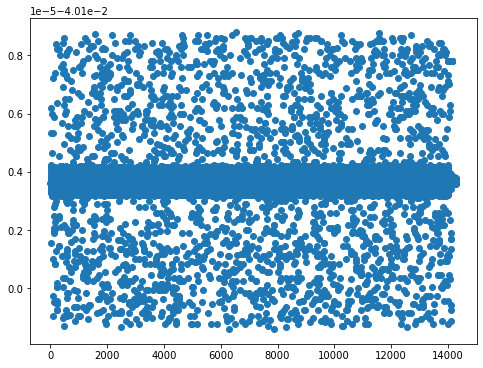

In [14]:
plt.scatter(x_axis, data[0,:,0])

In [15]:
data

array([[[-0.04009638, -0.04131178, -0.04226808, ...,  0.01324532,
          0.02055552,  0.02728652],
        [-0.0400963 , -0.0413117 , -0.0422681 , ...,  0.01324534,
          0.0205556 ,  0.0272869 ],
        [-0.04009629, -0.04131169, -0.04226809, ...,  0.01324531,
          0.02055561,  0.02728691],
        ...,
        [-0.04009638, -0.04131178, -0.04226818, ...,  0.01324525,
          0.02055552,  0.02728682],
        [-0.04009629, -0.04131169, -0.04226809, ...,  0.01324533,
          0.02055561,  0.02728691],
        [-0.04009626, -0.04131166, -0.04226806, ...,  0.01324539,
          0.02055564,  0.02728694]]])

## FOM data type : FOM_data = np.array[param, time, node, var]

In [16]:
FOM_data = np.zeros((num_param, num_time, num_node, num_var))

for i in range(num_var):
    for j in range(num_node):
        for k in range(num_param):
            for l in range(num_time):
                temp = l+k*num_time
                #print(l, k, temp)
                FOM_data[k,l,j,i]=data[i,j,temp]
                
FOM_data.shape

(10, 800, 14300, 1)

In [17]:
x_axis

array([0.00000000e+00, 1.00006993e+00, 2.00013987e+00, ...,
       1.42979999e+04, 1.42989999e+04, 1.43000000e+04])

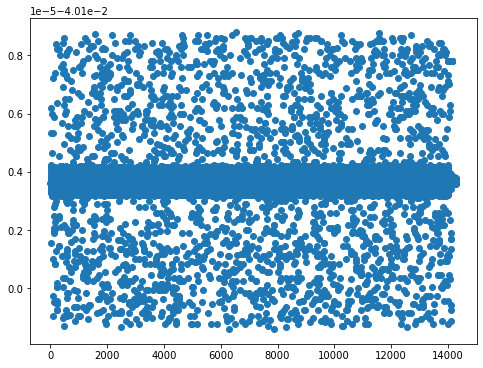

In [18]:
plt.scatter(x_axis, FOM_data[0,0,:,0])

In [19]:
# validate
print(FOM_data[0,0,0,0])
print(FOM_data[1,0,0,0])
print(FOM_data[0,1,0,0])
print(FOM_data[0,0,2,0])

-0.0400963761125
-0.0489409761125
-0.0413117761125
-0.040096287525


In [20]:
maximum = np.amax(FOM_data)
minimum = np.amin(FOM_data)
mean = np.mean(FOM_data)
AT = maximum-minimum

In [21]:
print(maximum)
print(minimum)
print(mean)
print(AT)

0.14354273825
-0.13646576825
-1.5900257024002243e-20
0.2800085065


In [22]:
FOM_data = FOM_data-mean
FOM_data = FOM_data/AT

In [23]:
print(np.max(FOM_data))
print(np.min(FOM_data))

0.5126370625100992
-0.48736293748990095


In [24]:
FOM_data.shape

(10, 800, 14300, 1)

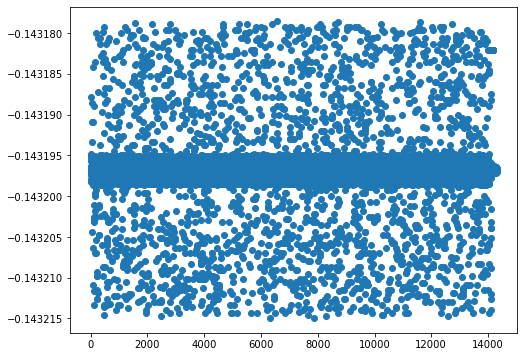

In [25]:
plt.scatter(x_axis, FOM_data[0,0,:,0])

# Level 1, SVAE (spatial VAE)

In [26]:
#Lv1_input = np.zeros((num_param*num_time, num_node, num_var))
# Lv1_input = (num_param x num_time, num_node, num_var)

Lv1_input = FOM_data.reshape(-1, num_node, num_var)
Lv1_input.shape
# Lv1_input is elongated w.r.t. param, 1,2,3,4,..../param change/1,2,3,4,.....

(8000, 14300, 1)

In [27]:
#validate

Lv1_input[200,0,0]
Lv1_input_shape_decoder = Lv1_input.shape[1]

In [28]:
Lv1_input_shape = Lv1_input.shape[1:]

In [29]:
print(Lv1_input.shape)
print(Lv1_input_shape)

(8000, 14300, 1)
(14300, 1)


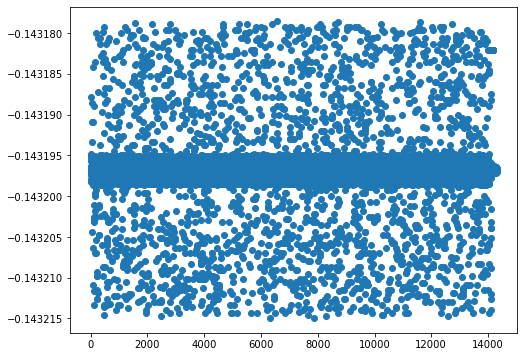

In [30]:
plt.scatter(x_axis, Lv1_input[0,:,0])

# Encoder

In [31]:
def encoder():
    x_input=layers.Input(shape=Lv1_input_shape)
    #x=layers.ZeroPadding1D(2)(x_input)
    
    x=layers.Conv1D(64, 5, strides=1, padding='same', kernel_initializer='glorot_uniform')(x_input)
    #x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU(0.2)(x)
    x=layers.Dropout(0.3)(x)
    
    x=layers.Conv1D(128, 5, strides=1, padding='same', kernel_initializer='glorot_uniform')(x)
    #x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU(0.2)(x)
    x=layers.Dropout(0.3)(x)   
    
    x=layers.Conv1D(256, 5, strides=1, padding='same', kernel_initializer='glorot_uniform')(x)
    #x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU(0.2)(x)
    x=layers.Dropout(0.3)(x)
    
    x=layers.Flatten()(x)
    x=layers.Dense(Lv1_latent_dim)(x)
    
    #mu=layers.Dense(Lv1_latent_dim, kernel_initializer='glorot_uniform')(x)
    #var=layers.Dense(Lv1_latent_dim, kernel_initializer='glorot_uniform')(x)
    #var=layers.Activation(tf.nn.softplus)(var) # var > 0
    
    #eps = tf.random.normal(shape=[Lv1_latent_dim], mean=0.0, stddev=1.0)
    #z = eps * tf.math.sqrt(var) + mu
    
    en_coder = tf.keras.models.Model(x_input, [x], name="ENCODER")
    return en_coder

Encoder=encoder()
Encoder.summary()
#tf.keras.utils.plot_model(Encoder, show_shapes=True)

Model: "ENCODER"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 14300, 1)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 14300, 64)         384       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14300, 64)         0         
_________________________________________________________________
dropout (Dropout)            (None, 14300, 64)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 14300, 128)        41088     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14300, 128)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14300, 128)        0   

# Decoder

In [32]:
print(Lv1_latent_dim)
print(Lv1_input_shape_decoder)

64
14300


In [33]:
def decoder():
    z_input=layers.Input(shape=(Lv1_latent_dim))
    
    z=layers.Dense(Lv1_input_shape_decoder*Lv1_latent_dim, kernel_initializer='glorot_uniform')(z_input)
    z=layers.LeakyReLU(alpha=0.3)(z)
    
    z=layers.Reshape([Lv1_input_shape_decoder,Lv1_latent_dim])(z)
        
    z=layers.Conv1DTranspose(256, 4, strides=1, padding='same', kernel_initializer='glorot_uniform')(z)
    #z=layers.BatchNormalization()(z)
    z=layers.LeakyReLU(alpha=0.3)(z)
    z=layers.Dropout(0.3)(z)
    
    z=layers.Conv1DTranspose(128, 4, strides=1, padding='same', kernel_initializer='glorot_uniform')(z)
    #z=layers.BatchNormalization()(z)
    z=layers.LeakyReLU(alpha=0.3)(z)
    z=layers.Dropout(0.3)(z)
    
    z=layers.Conv1DTranspose(64, 4, strides=1, padding='same', kernel_initializer='glorot_uniform')(z)
    #z=layers.BatchNormalization()(z)
    z=layers.LeakyReLU(alpha=0.3)(z)
    z=layers.Dropout(0.3)(z)    
    
    z=layers.Dense(num_var)(z)
    
    
    ## Changed Dense(1, ...) to Dense(num_var, ....)
    
    #z_mu=layers.Dense(num_var, kernel_initializer='glorot_uniform')(z)
    #mu_prime=layers.Activation('tanh')(z_mu)
    
    ## Changed Dense(1, ...) to Dense(num_var, ....)
    
    #z_var=layers.Dense(num_var, kernel_initializer='glorot_uniform')(z)
    #var_prime=layers.Activation(tf.nn.softplus)(z_var) # var > 0
    
    ## I guess the 
    
    
    de_coder = tf.keras.models.Model(z_input, [z], name="DECODER")
    return de_coder

Decoder=decoder()
Decoder.summary()
#tf.keras.utils.plot_model(Decoder, show_shapes=True)

Model: "DECODER"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 915200)            59488000  
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 915200)            0         
_________________________________________________________________
reshape (Reshape)            (None, 14300, 64)         0         
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 14300, 256)        65792     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14300, 256)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 14300, 256)        0   

# loss computation

In [34]:
def compute_loss(real_img, fake_img):
    
    reconstruction_error = tf.math.reduce_mean(tf.math.reduce_sum(tf.math.square(real_img) + tf.math.square(fake_img)))
    
    
    loss = reconstruction_error
    
    return loss

# VAE

In [35]:
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, ENCODER, DECODER):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.ENCODER = ENCODER
        self.DECODER = DECODER
        
    def compile(self, opt, loss):
        super(VAE, self).compile()
        self.opt = opt
        self.loss = loss

    def train_step(self, real_img):
        if isinstance(data, tuple):
            real_img = real_img[0]
            
        with tf.GradientTape() as tape:
            # encoding
            latent_space = self.ENCODER(real_img, training=True)
            
            # decoding
            fake_img = self.DECODER(latent_space, training=True)
            
            # loss calculation
            loss = self.loss(real_img, fake_img)
            
        gradients = tape.gradient(loss, self.trainable_variables)
        self.opt.apply_gradients(zip(gradients, self.trainable_variables))
        return {"loss": loss}


# Save Model

In [36]:
class SaveModel(tf.keras.callbacks.Callback):
    def __init__(self, num_iter=n_epochs, latent_dim=Lv1_latent_dim):
        self.num_iter = num_iter
        self.latent_dim = Lv1_latent_dim
        
    def on_epoch_end(self, epoch, logs=None):
        if((epoch+1)%1000==0):
            if((epoch+1)%1000==0):          
                filename1 = 'test_constrained_ae/decoder_%dbatchnorm.h5' % (epoch+1)
                filename2 = 'test_constrained_ae/encoder_%dbatchnorm.h5' % (epoch+1)
                
                Decoder.save(filename1)
                Encoder.save(filename2)

In [37]:
print(Lv1_input.shape)
print(type(Lv1_input))

(8000, 14300, 1)
<class 'numpy.ndarray'>


# Warm up

In [38]:
beta = K.variable(0.)
N_t = int(n_epochs * 0.25)

class WarmUp(tf.keras.callbacks.Callback):
    def __init__(self, beta):
        self.beta = beta
        
    def on_epoch_begin(self, epoch, logs=None):
        if epoch < N_t:
            K.set_value(self.beta, epoch / N_t)
        else:
            K.set_value(self.beta, 1)


In [39]:
opt = tf.keras.optimizers.Adam(learning_rate=LR, beta_1=0.5, beta_2=0.99)

cbk1 = SaveModel(num_iter=n_epochs,latent_dim=Lv1_latent_dim)
cbk2 = WarmUp(beta)

#with strategy.scope():
vae = VAE(latent_dim=Lv1_latent_dim, ENCODER=Encoder, DECODER=Decoder)
vae.compile(opt=opt, loss=losses.MeanSquaredError())

start = time.time()
vae.fit(Lv1_input, batch_size=batch_size, epochs=n_epochs, callbacks=[cbk1, cbk2])
end = time.time()

print(end-start)

Epoch 1/20000
800/800 [==============================] - 110s 129ms/step - loss: 0.0033
Epoch 2/20000
800/800 [==============================] - 102s 128ms/step - loss: 0.0011
Epoch 3/20000
800/800 [==============================] - 102s 127ms/step - loss: 9.1104e-04
Epoch 4/20000
800/800 [==============================] - 101s 127ms/step - loss: 8.0357e-04
Epoch 5/20000
800/800 [==============================] - 101s 127ms/step - loss: 7.6047e-04
Epoch 6/20000
800/800 [==============================] - 101s 127ms/step - loss: 7.1702e-04
Epoch 7/20000
800/800 [==============================] - 101s 127ms/step - loss: 6.9468e-04
Epoch 8/20000
800/800 [==============================] - 102s 127ms/step - loss: 6.7367e-04
Epoch 9/20000
800/800 [==============================] - 102s 127ms/step - loss: 6.5633e-04
Epoch 10/20000
800/800 [==============================] - 102s 127ms/step - loss: 6.4247e-04
Epoch 11/20000
800/800 [==============================] - 102s 127ms/step - loss: 6.323

800/800 [==============================] - 102s 128ms/step - loss: 4.9074e-04
Epoch 87/20000
800/800 [==============================] - 102s 127ms/step - loss: 4.9045e-04
Epoch 88/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.8985e-04
Epoch 89/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.8956e-04
Epoch 90/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.8904e-04
Epoch 91/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.8866e-04
Epoch 92/20000
800/800 [==============================] - 102s 127ms/step - loss: 4.8870e-04
Epoch 93/20000
800/800 [==============================] - 102s 127ms/step - loss: 4.8777e-04
Epoch 94/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.8742e-04
Epoch 95/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.8733e-04
Epoch 96/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.8

800/800 [==============================] - 102s 128ms/step - loss: 4.7096e-04
Epoch 174/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.6938e-04
Epoch 175/20000
800/800 [==============================] - 102s 127ms/step - loss: 4.6997e-04
Epoch 176/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.6969e-04
Epoch 177/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.6989e-04
Epoch 178/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.6940e-04
Epoch 179/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.6926e-04
Epoch 180/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.6928e-04
Epoch 181/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.7004e-04
Epoch 182/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.6921e-04
Epoch 183/20000
800/800 [==============================] - 102s 128ms/step -

800/800 [==============================] - 102s 127ms/step - loss: 4.6254e-04
Epoch 261/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.6268e-04
Epoch 262/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.6366e-04
Epoch 263/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.6289e-04
Epoch 264/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.6253e-04
Epoch 265/20000
800/800 [==============================] - 102s 127ms/step - loss: 4.6261e-04
Epoch 266/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.6232e-04
Epoch 267/20000
800/800 [==============================] - 102s 127ms/step - loss: 4.6238e-04
Epoch 268/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.6217e-04
Epoch 269/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.6201e-04
Epoch 270/20000
800/800 [==============================] - 102s 128ms/step -

800/800 [==============================] - 102s 128ms/step - loss: 4.5894e-04
Epoch 348/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.5871e-04
Epoch 349/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.5860e-04
Epoch 350/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.5906e-04
Epoch 351/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.5842e-04
Epoch 352/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.5838e-04
Epoch 353/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.5864e-04
Epoch 354/20000
800/800 [==============================] - 102s 127ms/step - loss: 4.5860e-04
Epoch 355/20000
800/800 [==============================] - 102s 127ms/step - loss: 4.5834e-04
Epoch 356/20000
800/800 [==============================] - 102s 127ms/step - loss: 4.5818e-04
Epoch 357/20000
800/800 [==============================] - 102s 127ms/step -

800/800 [==============================] - 103s 128ms/step - loss: 4.5674e-04
Epoch 435/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.5639e-04
Epoch 436/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.5617e-04
Epoch 437/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.5628e-04
Epoch 438/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.5657e-04
Epoch 439/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.5631e-04
Epoch 440/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.5658e-04
Epoch 441/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.5647e-04
Epoch 442/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.5639e-04
Epoch 443/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.5632e-04
Epoch 444/20000
800/800 [==============================] - 102s 128ms/step -

800/800 [==============================] - 102s 128ms/step - loss: 4.5504e-04
Epoch 522/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.5482e-04
Epoch 523/20000
800/800 [==============================] - 102s 127ms/step - loss: 4.5454e-04
Epoch 524/20000
800/800 [==============================] - 102s 127ms/step - loss: 4.5507e-04
Epoch 525/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.5476e-04
Epoch 526/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.5476e-04
Epoch 527/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.5506e-04
Epoch 528/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.5507e-04
Epoch 529/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.5437e-04
Epoch 530/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.5491e-04
Epoch 531/20000
800/800 [==============================] - 102s 128ms/step -

800/800 [==============================] - 100s 125ms/step - loss: 4.5404e-04
Epoch 609/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.5405e-04
Epoch 610/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.5390e-04
Epoch 611/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.5404e-04
Epoch 612/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.5371e-04
Epoch 613/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.5434e-04
Epoch 614/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.5350e-04
Epoch 615/20000
800/800 [==============================] - 102s 127ms/step - loss: 4.5384e-04
Epoch 616/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.5388e-04
Epoch 617/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.5377e-04
Epoch 618/20000
800/800 [==============================] - 102s 128ms/step -

800/800 [==============================] - 102s 128ms/step - loss: 4.5271e-04
Epoch 696/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.5281e-04
Epoch 697/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.5303e-04
Epoch 698/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.5293e-04
Epoch 699/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.5332e-04
Epoch 700/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.5312e-04
Epoch 701/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.5293e-04
Epoch 702/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.5294e-04
Epoch 703/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.5275e-04
Epoch 704/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.5310e-04
Epoch 705/20000
800/800 [==============================] - 102s 128ms/step -

800/800 [==============================] - 102s 128ms/step - loss: 4.5210e-04
Epoch 783/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.5219e-04
Epoch 784/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.5226e-04
Epoch 785/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.5220e-04
Epoch 786/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.5207e-04
Epoch 787/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.5246e-04
Epoch 788/20000
800/800 [==============================] - 102s 127ms/step - loss: 4.5234e-04
Epoch 789/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.5220e-04
Epoch 790/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.5189e-04
Epoch 791/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.5255e-04
Epoch 792/20000
800/800 [==============================] - 102s 128ms/step -

800/800 [==============================] - 102s 128ms/step - loss: 4.5090e-04
Epoch 870/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.5126e-04
Epoch 871/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.5126e-04
Epoch 872/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.5130e-04
Epoch 873/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.5152e-04
Epoch 874/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.5130e-04
Epoch 875/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.5126e-04
Epoch 876/20000
800/800 [==============================] - 102s 127ms/step - loss: 4.5124e-04
Epoch 877/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.5125e-04
Epoch 878/20000
800/800 [==============================] - 102s 128ms/step - loss: 4.5142e-04
Epoch 879/20000
800/800 [==============================] - 102s 128ms/step -

800/800 [==============================] - 49s 61ms/step - loss: 4.5086e-04
Epoch 957/20000
800/800 [==============================] - 48s 61ms/step - loss: 4.5049e-04
Epoch 958/20000
800/800 [==============================] - 49s 61ms/step - loss: 4.5061e-04
Epoch 959/20000
800/800 [==============================] - 48s 61ms/step - loss: 4.5100e-04
Epoch 960/20000
800/800 [==============================] - 48s 61ms/step - loss: 4.5070e-04
Epoch 961/20000
800/800 [==============================] - 48s 61ms/step - loss: 4.5045e-04
Epoch 962/20000
800/800 [==============================] - 48s 61ms/step - loss: 4.5095e-04
Epoch 963/20000
800/800 [==============================] - 48s 61ms/step - loss: 4.5071e-04
Epoch 964/20000
800/800 [==============================] - 48s 61ms/step - loss: 4.5061e-04
Epoch 965/20000
800/800 [==============================] - 48s 61ms/step - loss: 4.5045e-04
Epoch 966/20000
800/800 [==============================] - 48s 61ms/step - loss: 4.5033e-04
Epoc

KeyboardInterrupt: 

# Acquire latent vectors